# IMDB EDA
Initial exploration of the imdb data with the following goals: 
- What columns exist in the data? 
- How much? 
- How long are the documents? 

### Important notes
- Raw data is in `../data/aclimdb_v1.tar.gz`

In [4]:
from pathlib import Path
from typing import Dict, Union, List
import tarfile
import numpy as np
import re
import pandas as pd
import fileinput as fi

DATA_DIR = Path("../data/")

In [3]:
def glob_text_dat(dr: Path) -> List[Path]:
    return list(dr.glob("*.txt"))

def glob_all_reviews(dr: Path) -> List[Path]:
    return glob_text_dat(dr / "pos") + glob_text_dat(dr / "neg")

def read_review(review_path: Path) -> str:
    with open(review_path, "r", encoding="utf8") as f:
        return f.readline()

def review_to_row(line: str, review_path: Path) -> Dict[str, Union[str, int]]:
    review_id = review_path.name[:-4]
    label = 1 if review_path.parent.name == "pos" else 0
    origin = review_path.parent.parent.name
    return {"id": review_id, "origin": origin, "text": line, "label": label}

    
def get_movie_id(movie_url: str) -> str:
    return re.search("tt\d+", movie_url).group()

In [13]:
# Unzipping the data files :)
data_path = next(DATA_DIR.glob("*tar.gz"))

if not (DATA_DIR / "aclimdb").exists():
    with tarfile.open(data_path, 'r:gz') as tar:
        tar.extractall(path = DATA_DIR)
                

## Create useful training data 
Now that they are unzipped, I will put them into a pandas dataframe which is easier to load :))

In [5]:

MAIN_DIR = DATA_DIR / "aclimdb"

test_paths = glob_all_reviews(MAIN_DIR / "test")
train_paths = glob_all_reviews(MAIN_DIR / "train")
all_paths = test_paths + train_paths

In [7]:
i = 0
review_list = [dict.fromkeys(["id", "origin", "text", "label"]) for _ in range(len(all_paths))]
with fi.input(all_paths, openhook=fi.hook_encoded("utf-8")) as f:
    for line in f:
        review_list[i] = review_to_row(line, f.filename())
        i += 1
        if i % 5000 == 0:
            print(f"done processing {i} files")

done processing 5000 files
done processing 10000 files
done processing 15000 files
done processing 20000 files
done processing 25000 files
done processing 30000 files
done processing 35000 files
done processing 40000 files
done processing 45000 files
done processing 50000 files


In [8]:
all_data = pd.DataFrame.from_records(review_list)
all_data.to_csv(DATA_DIR / "all_data.csv")
all_data = pd.read_csv(DATA_DIR / "all_data.csv")

## Splitting into train test
Now I split into test set making sure not to have leakage for movies :))

In [9]:
all_movies = pd.DataFrame(columns = ["movie_id", "source", "linenum"], index = range(len(test_paths)))
with fi.input((MAIN_DIR / "test").glob("*.txt"), openhook=fi.hook_encoded("utf-8")) as f:
    for i, line in enumerate(f):
        all_movies.loc[i, "movie_id"] = line
        all_movies.loc[i, "linenum"] = f.filelineno() - 1
        all_movies.loc[i, "source"] = f.filename().name
all_movies["movie_id"] = all_movies["movie_id"].str.extract("tt(\d+)").values
all_movies["source"] = all_movies["source"].str.contains("pos").astype(int)

In [10]:
# Randomly choose N hundred movies
N = 700
unique_movies = all_movies["movie_id"].unique()
np.random.seed(42)
target_movies = np.random.choice(unique_movies, N)

# Create ids
test_movies = all_movies[all_movies["movie_id"].isin(target_movies)]
test_ids = test_movies["source"].astype(str) + "_" + test_movies["linenum"].astype(str)

In [40]:
all_data["test_id"] = all_data["label"].astype(str) + "_" + pd.Series(all_data["id"].str.extract("(\d+)_\d+").values.reshape((-1, )))
all_data.loc[all_data["origin"] == "train", "test_id"]  = None

In [56]:
test_data = all_data.loc[all_data["test_id"].isin(test_ids), ["text", "label"]].reset_index(drop=True)
train_data = all_data.loc[~all_data["test_id"].isin(test_ids), ["text", "label"]].reset_index(drop=True)
test_data.to_csv(DATA_DIR / "imdb_test.csv")
train_data.to_csv(DATA_DIR / "imdb_train.csv")

## Checking data quality

longest review is 13704 characters
docs too long for BERT: 44843
docs too long for Longformer: 1394


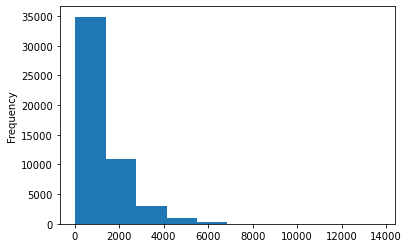

In [61]:
def rows_longer_than(text_series: pd.Series, cutoff=int) -> int:
    return (text_series.str.len() > cutoff).sum()

# Review length
all_data["text"].str.len().plot.hist()
print(f"longest review is {all_data['text'].str.len().max()} characters")
print(f"docs too long for BERT: {rows_longer_than(all_data['text'], 512)}")
print(f"docs too long for Longformer: {rows_longer_than(all_data['text'], 4096)}")



## Length notes
It seems that most reviews are relatively short with a few extremely long ones. I'll also have to deal with some kind of truncation but that seems to be possible from the literature. 